In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
# Download dataset containing thousand images of pandas and polar bears scraped from Google, Bing and Baidu.
_URL = 'https://media.githubusercontent.com/media/zhou997/image_classification/main/pandas_and_polar_bears.zip'
path_to_zip = tf.keras.utils.get_file('pandas_and_polar_bears.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'pandas_and_polar_bears')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32

# The model EfficientNetB0 takes input images of shape (224, 224, 3), and the input data should range [0, 255].
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3000 files belonging to 2 classes.
Found 1363 files belonging to 2 classes.


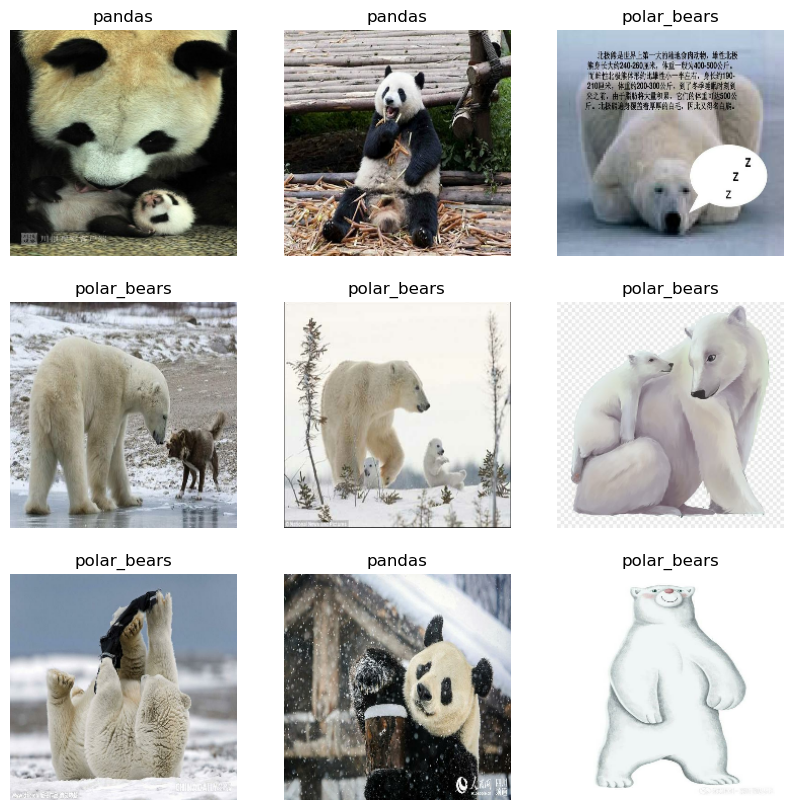

In [7]:
class_names = train_dataset.class_names

# Draw the first 9 images with lable from train_dataset.
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
# Create a test_dataset by moving 20% from the validation set.
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 35
Number of test batches: 8


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

# Load images use buffered prefetching, decouple the time when data is produced from the time when data is consumed.
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
# Use the Keras preprocessing layers for data augmentation to reduce overfitting.
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

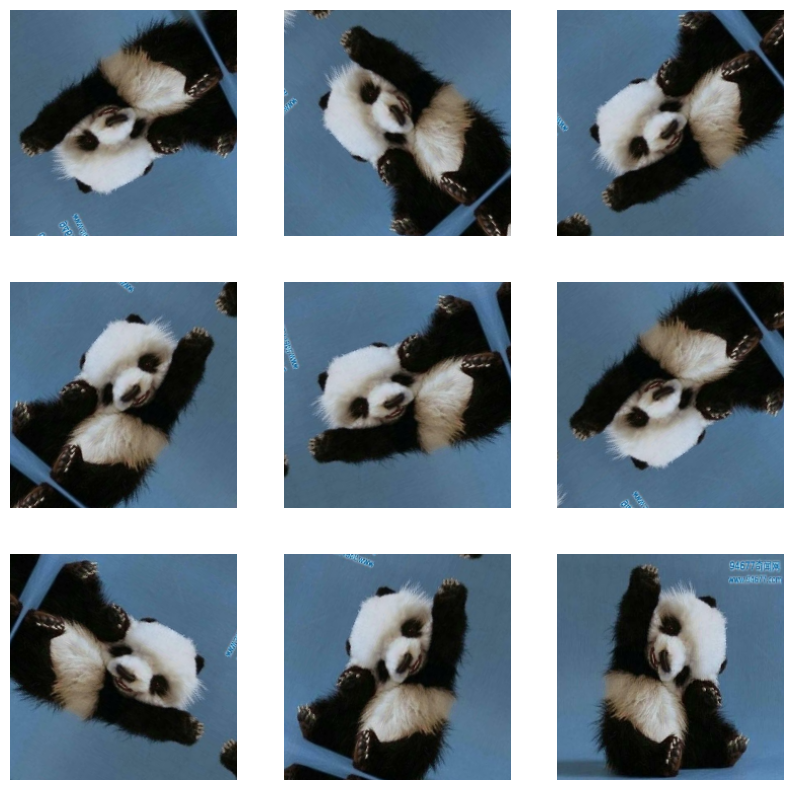

In [16]:
# See what data_augmentation function does to the first image.
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [17]:
#(224, 224, 3).
IMG_SHAPE = IMG_SIZE + (3,)

# Create a base model from the pre-trained model EfficientNet
# Disable the classification layers at the top for eature extraction
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))

In [18]:
# Feature extraction
print(image_batch.shape)
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# Freeze all layers and train only the top layers, to prevents the weights in a given layer from being updated during training.
base_model.trainable = False

# Convert the features to a single 1280-element vector per image.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Convert features into a single prediction per image by Dense Layer.
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 224, 224, 3)
(32, 7, 7, 1280)
(32, 1280)
(32, 1)


In [19]:
#Build a model.
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
# Compile
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())
print(len(model.trainable_variables))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                             

In [21]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

35/35 [==============================] - 47s 1s/step - loss: 0.8079 - accuracy: 0.3659
initial loss: 0.81
initial accuracy: 0.37


In [22]:
# First training
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
94/94 [==============================] - 163s 2s/step - loss: 0.6864 - accuracy: 0.5360 - val_loss: 0.5882 - val_accuracy: 0.6676
Epoch 2/10
94/94 [==============================] - 157s 2s/step - loss: 0.5073 - accuracy: 0.7330 - val_loss: 0.4540 - val_accuracy: 0.8383
Epoch 3/10
94/94 [==============================] - 156s 2s/step - loss: 0.3977 - accuracy: 0.8343 - val_loss: 0.3643 - val_accuracy: 0.9042
Epoch 4/10
94/94 [==============================] - 157s 2s/step - loss: 0.3330 - accuracy: 0.8720 - val_loss: 0.3109 - val_accuracy: 0.9133
Epoch 5/10
94/94 [==============================] - 156s 2s/step - loss: 0.2855 - accuracy: 0.9000 - val_loss: 0.2708 - val_accuracy: 0.9268
Epoch 6/10
94/94 [==============================] - 156s 2s/step - loss: 0.2475 - accuracy: 0.9193 - val_loss: 0.2369 - val_accuracy: 0.9368
Epoch 7/10
94/94 [==============================] - 158s 2s/step - loss: 0.2263 - accuracy: 0.9223 - val_loss: 0.2198 - val_accuracy: 0.9386
Epoch 8/10
94

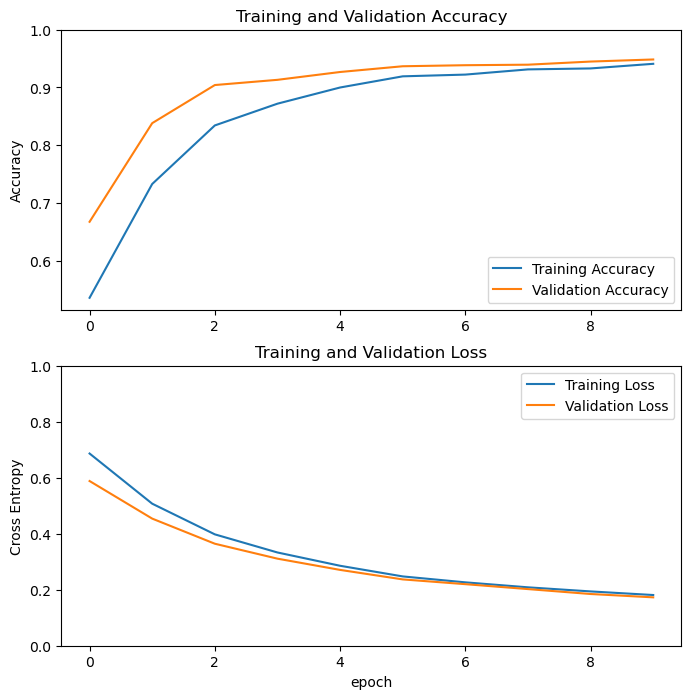

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
# Transfer learning from pre-trained weights.
# Unfreeze a number of layers and fit the model using smaller learning rate.
base_model.trainable = True

# Show how many layers are in the base model.
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  238


In [25]:
# Fine-tune from this layer onwards
fine_tune_at = 180

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
print('Trainable_variables: ', len(model.trainable_variables))

Trainable_variables:  54


In [26]:
# Second training
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
94/94 [==============================] - 180s 2s/step - loss: 0.1420 - accuracy: 0.9467 - val_loss: 0.1199 - val_accuracy: 0.9575
Epoch 11/20
94/94 [==============================] - 189s 2s/step - loss: 0.1086 - accuracy: 0.9587 - val_loss: 0.0951 - val_accuracy: 0.9612
Epoch 12/20
94/94 [==============================] - 189s 2s/step - loss: 0.0914 - accuracy: 0.9650 - val_loss: 0.0861 - val_accuracy: 0.9666
Epoch 13/20
94/94 [==============================] - 188s 2s/step - loss: 0.0792 - accuracy: 0.9697 - val_loss: 0.0758 - val_accuracy: 0.9729
Epoch 14/20
94/94 [==============================] - 189s 2s/step - loss: 0.0664 - accuracy: 0.9743 - val_loss: 0.0778 - val_accuracy: 0.9729
Epoch 15/20
94/94 [==============================] - 190s 2s/step - loss: 0.0589 - accuracy: 0.9777 - val_loss: 0.0710 - val_accuracy: 0.9747
Epoch 16/20
94/94 [==============================] - 190s 2s/step - loss: 0.0574 - accuracy: 0.9777 - val_loss: 0.0707 - val_accuracy: 0.9765
Epoch 

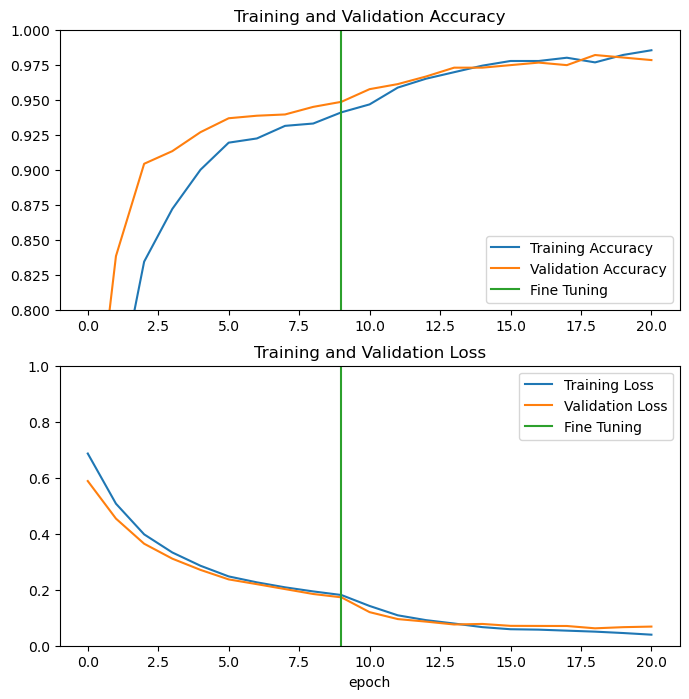

In [27]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [28]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

8/8 [==============================] - 8s 946ms/step - loss: 0.0750 - accuracy: 0.9727
Test accuracy : 0.97265625


Predictions:
 [0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0]
Labels:
 [0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0]


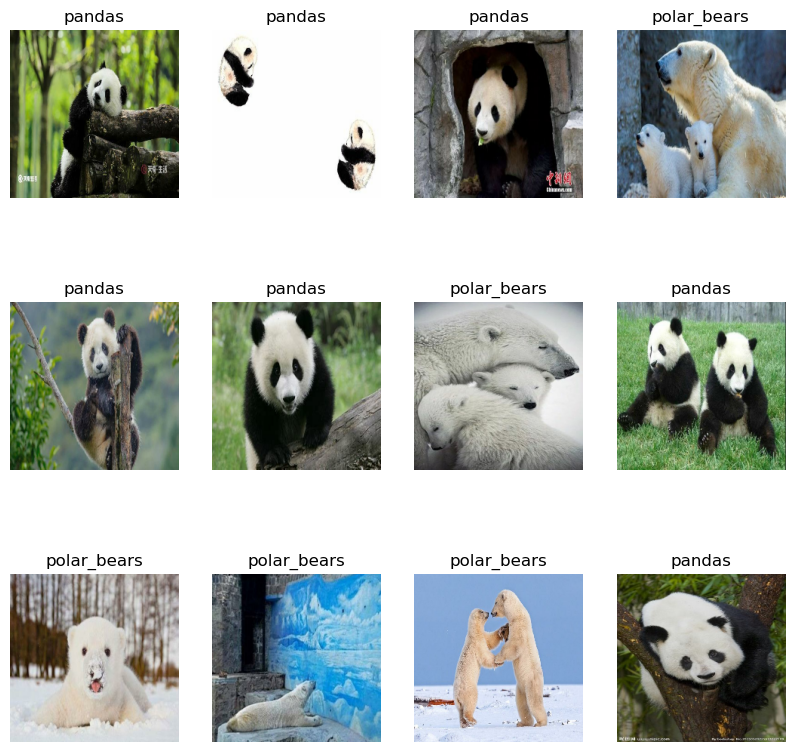

In [31]:
# Retrieve images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(12):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")